In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.stats.multicomp

%pip install bioinfokit
from bioinfokit.analys import stat

Note: you may need to restart the kernel to use updated packages.


In [2]:
### Loading and Reading data file ###
Data = pd.read_excel("INF2178_A2_data.xlsx", sheet_name="ChildCareCentres")

In [3]:
### Data Preprocessing ###
# Relabelling the variables based on data descriptions 
dict = {'IGSPACE': 'Infants_Cap',
        'TGSPACE': 'Toddlers_Cap',
        'PGSPACE': 'Preschoolers_Cap', 
        'KGSPACE': 'Kindergarteners_Cap',
        'SGSPACE': 'GradeOne_Cap',
        'TOTSPACE': 'Total_Cap', 
        'bldg_type': 'Building_Type'}

Data.rename(columns=dict,
          inplace=True)

In [4]:
# Converting '_id', 'LOC_ID' and 'ward' columns to string type
Data['_id'] = Data['_id'].astype(str)
Data['LOC_ID'] = Data['LOC_ID'].astype(str)
Data['ward'] = Data['ward'].astype(str)

In [5]:
### Summary Statistics of centre capacity across ages ###

## Restructuring the data for account for non-zero values to get accurate summary of centre capacity
# Creating a new dataset for age-based capacity columns
Age_Data_DF = Data[["Infants_Cap", "Toddlers_Cap", "Preschoolers_Cap", "Kindergarteners_Cap", "GradeOne_Cap"]]

# Replacing 0 with NaN values 
Age_Data_DF.replace(0, np.nan, inplace=True)

# Creating base descriptive stats df
Summary_Stats_DF = pd.DataFrame(Age_Data_DF.describe())

# Relabelling index names 
Summary_Stats_DF = Summary_Stats_DF.rename(index={'count': 'Count', 
                                                  'mean': 'Mean', 
                                                  '50%': 'Median', 
                                                  'std': 'Standard Deviation', 
                                                  'min': 'Minimum', 
                                                  'max': 'Maximum', 
                                                  '25%': 'Quartile 1',
                                                  '75%': 'Quartile 3'})

# Reordering DF index for readability 
Summary_Stats_DF = Summary_Stats_DF.reindex(index=['Count', 'Mean', 'Standard Deviation',
                                                   'Median', 'Minimum', 'Maximum', 
                                                  'Quartile 1', 'Quartile 3'])

# Displaying summary statistics table for centre capacity across age groups 
Summary_Stats_DF

,Infants_Cap,Toddlers_Cap,Preschoolers_Cap,Kindergarteners_Cap,GradeOne_Cap
Count,359.000000,670.000000,854.00000,461.000000,505.000000
Mean,11.537604,18.404478,30.19555,32.876356,45.596040
Standard Deviation,4.656119,10.322120,15.81785,18.871992,29.272108
Median,10.000000,15.000000,24.00000,26.000000,30.000000
Minimum,4.000000,2.000000,1.00000,5.000000,6.000000
Maximum,30.000000,90.000000,144.00000,130.000000,285.000000
Quartile 1,10.000000,10.000000,20.00000,24.000000,30.000000
Quartile 3,10.000000,20.000000,38.00000,48.000000,60.000000


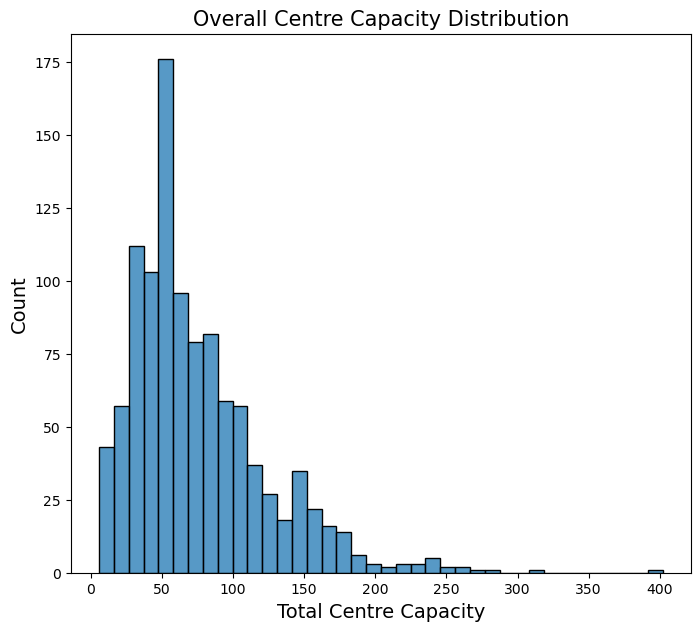

In [6]:
### Overall distribution of capacity ###
# Setting plot dimensions
plt.figure(figsize=(8, 7))

# Plot the histogram thanks to the displot function
sns.histplot( data=Data["Total_Cap"])

# Adding title and axis names
plt.xlabel('Total Centre Capacity',size = 14) 
plt.ylabel('Count',size = 14) 
plt.title('Overall Centre Capacity Distribution', size = 15) 

# Display graph
plt.show()

In [7]:
### Total Capacity Distribution across Auspice and Building Type ###

# Creating new DF 
Cap_Dist_DF = Data[["AUSPICE", "Building_Type", "Total_Cap"]]

# Grouped by auspice and building type, aggregated for total capacity 
Grouped_AggCap_DF = Cap_Dist_DF.groupby(['AUSPICE','Building_Type' ]).agg({'Total_Cap': ['sum']})
# Renaming the aggregated sum column
Grouped_AggCap_DF.columns = ['Total_Capacity_Sum']
# Displaying table
Grouped_AggCap_DF


Total_Capacity_Sum
AUSPICE                       Building_Type                                       
Commercial Agency             Church                                           471
                              Commercial Building                             1076
                              Community Rec/Centre - Board Run                 180
                              Community/Rec Centre - Private                    67
                              Community/Recreation Centre                      320
                              High Rise Apartment                             2727
                              House                                           1252
                              Industrial Building                              228
                              Low Rise Apartment                                92
                              Multi Human Services Facility                     91
                              Office Building                                  955
                              Other                                           8891
                              Place of Worship                                2053
                              Private Elementary School                        431
                              Public (school closed)                           125
                              Public Elementary School                         874
                              Purpose Built                                   1027
Non Profit Agency             Catholic Elementary (French)                     880
                              Catholic Elementary School                      7793
                              Catholic High School                             194
                              Church                                           399
                              Commercial Building                              266
                              Community College/University                     298
                              Community Health Centre                           49
                              Community/Rec Centre - City                      352
                              Community/Rec Centre AOCC                         74
                              Community/Recreation Centre                     1745
                              High Rise Apartment                             1043
                              Hospital/Health Centre                            87
                              House                                            362
                              Low Rise Apartment                               203
                              Office Building                                  272
                              Other                                           5159
                              Place of Worship                                2102
                              Private Elementary School                        169
                              Public (school closed)                           337
                              Public Elementary (French)                      1567
                              Public Elementary School                       30628
                              Public Elementary Special                        101
                              Public High School                               983
                              Public Middle School                              58
                              Purpose Built                                   2078
                              Synagogue                                        520
Public (City Operated) Agency Community/Recreation Centre                      219
                              High Rise Apartment                              220
                              Low Rise Apartment                               106
                              Multi Human Services Facility                     

In [8]:
### Which ward has the most centres and biggest capacity? ###

# Creating new DF with relevant variables 
Ward_Cap_DF = Data[['ward', 'Total_Cap']]

# # Creating new DF for centre counts for wards
Ward_Centre_Counts = pd.DataFrame(Ward_Cap_DF['ward'].value_counts())
# Relabelling column name
Ward_Centre_Counts.columns = ['Centre Count']
# Ward_Centre_Counts

# Creating new DF for capacity distribution for wards
Ward_Cap_Dist_DF = Ward_Cap_DF.groupby(['ward']).agg({'Total_Cap': ['sum']})
Ward_Cap_Dist_DF.columns = ['Total_Capacity_Sum']
# Sorting values in descending order
Ward_Cap_Dist_DF = Ward_Cap_Dist_DF.sort_values(by="Total_Capacity_Sum", ascending=False)

## Using function to display table side by side 
import pandas as pd
from IPython.display import HTML

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))
    

side_by_side(Ward_Centre_Counts, Ward_Cap_Dist_DF)

,Centre Count
3,61
19,60
14,58
4,56
8,53
15,48
2,48
12,47
10,46
17,45


In [9]:
### Are most centres subsized and participating in CWELLC? ###

# Grouping base data with relevant variables and calculating counts
Data.groupby(['subsidy', 'cwelcc_flag']).size().unstack(fill_value=0)

cwelcc_flag,N,Y
subsidy,,
N,124,221
Y,13,705


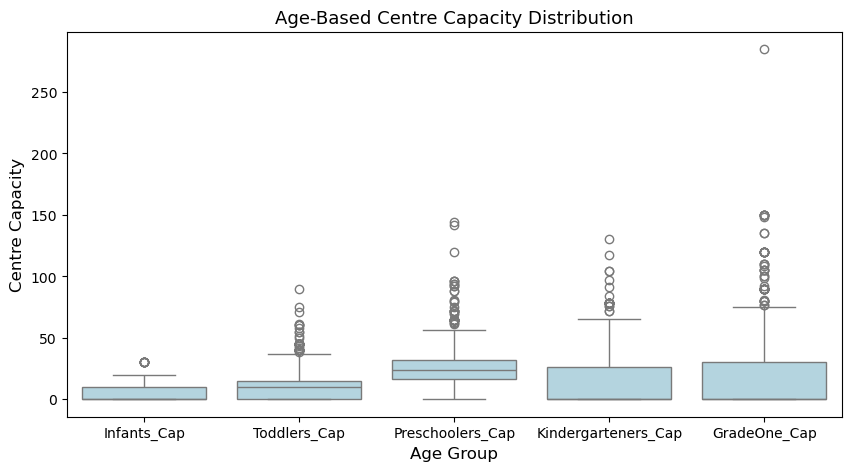

In [10]:
##### ANOVA One Way - I  #####

### To see the impact of age on centre capacity ###
# H0: The centre capacity means across age groups are all equal 
# H1: There is at least one difference in centre capacity means among the age groups

# Creating and restructuring new DF with age based capacity columns
Age_Cap_DF = pd.melt(Data.reset_index(), id_vars=['index'], value_vars=["Infants_Cap", "Toddlers_Cap", "Preschoolers_Cap", "Kindergarteners_Cap", "GradeOne_Cap"])

# Replacing column names
Age_Cap_DF.columns = ['index', 'Age_Group', 'Capacity']

# Plotting boxplot to the capacity distribution across the age groups

# Setting plot dimensions
plt.figure(figsize=(10, 5))

ax = sns.boxplot(x='Age_Group', y='Capacity', data=Age_Cap_DF, color='lightblue')

# Adding title and axis names
plt.xlabel('Age Group',size = 12) 
plt.ylabel('Centre Capacity',size = 12) 
plt.title('Age-Based Centre Capacity Distribution', size = 13) 

# Display graph
plt.show()

In [11]:
# Running one-way ANOVA 
AgeCapANOVA_Res = stat()
AgeCapANOVA_Res.anova_stat(df=Age_Cap_DF, res_var='Capacity', anova_model='Capacity ~ C(Age_Group)')
# ANOVA Results Table
AgeCap_ANOVATable = pd.DataFrame(round(AgeCapANOVA_Res.anova_summary, 3))

# Printing ANOVA table
display(AgeCap_ANOVATable)

# Adding space between the outputs 
print (" ")

# Defining level of significance
level_of_sig = 0.05

# Printing conclusion of test
if(AgeCap_ANOVATable['PR(>F)'][0] != '0.0'):
    if(AgeCap_ANOVATable['PR(>F)'][0] < level_of_sig):
        print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the mean centre capacities of different age groups")
    else:
        print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove signficant differences among the mean centre capacities of different age groups")   
    
else:
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the mean centre capacities of different age groups")
    

,df,sum_sq,mean_sq,F,PR(>F)
C(Age_Group),4.0,282123.267,70530.817,188.191,0.0
Residual,5310.0,1990101.008,374.784,NaN,NaN


 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the mean centre capacities of different age groups


In [12]:
# Post hoc test for multiple pairwise comparisons using Tukey's HSD Test
AgeCapANOVA_Res.tukey_hsd(df=Age_Cap_DF, res_var='Capacity', xfac_var='Age_Group', anova_model='Capacity ~ C(Age_Group)')
AgeCapANOVA_Res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Infants_Cap,Toddlers_Cap,7.703669,5.412308,9.995029,12.974001,0.001000
1,Infants_Cap,Preschoolers_Cap,20.362183,18.070822,22.653543,34.292619,0.001000
2,Infants_Cap,Kindergarteners_Cap,10.361242,8.069881,12.652602,17.449707,0.001000
3,Infants_Cap,GradeOne_Cap,17.764817,15.473456,20.056177,29.918310,0.001000
4,Toddlers_Cap,Preschoolers_Cap,12.658514,10.367153,14.949874,21.318618,0.001000
5,Toddlers_Cap,Kindergarteners_Cap,2.657573,0.366213,4.948933,4.475706,0.013527
6,Toddlers_Cap,GradeOne_Cap,10.061148,7.769787,12.352508,16.944309,0.001000
7,Preschoolers_Cap,Kindergarteners_Cap,10.000941,7.709580,12.292301,16.842912,0.001000
8,Preschoolers_Cap,GradeOne_Cap,2.597366,0.306006,4.888726,4.374309,0.017028
9,Kindergarteners_Cap,GradeOne_Cap,7.403575,5.112214,9.694935,12.468603,0.001000


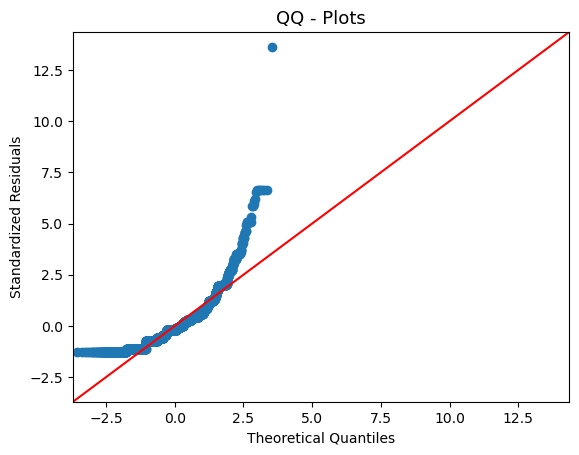

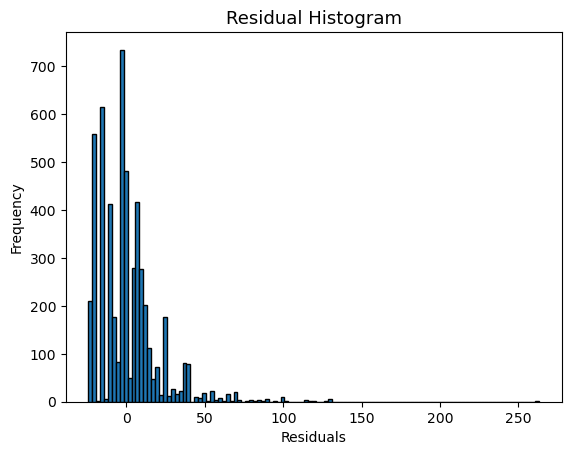

In [13]:
# Checking anova model diagnostics

# Assumption 1: res.anova_std_residuals are standardized residuals obtained from ANOVA
sm.qqplot(AgeCapANOVA_Res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title('QQ - Plots', size = 13) 
plt.show()

# histogram
plt.hist(AgeCapANOVA_Res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.title('Residual Histogram', size = 13) 


# show plot
plt.show()

In [14]:
# Assumption 1: Residuals are normally distributed; testing using Shapiro Wilk test
# H0: Data is normally distributed
# H1: Data is not normally distributed

# Defining level of significance
level_of_sig = 0.05

# Running test
w_age, p_val_age = stats.shapiro(AgeCapANOVA_Res.anova_model_out.resid)

w_age = round(w_age, 3)
p_val_age = round(p_val_age, 3)
# Printing results
print('Age Groups - Test statistic :', w_age)

if(p_val_age == 0.0):
    print('Age Groups - p-value < 0.001')
else:
    print('Age Groups - p-value :',p_val_age)    


# Adding space between the outputs 
print(' ')

# Printing conclusion of test
if(p_val_age < level_of_sig):
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there is sample is not normally distributed")
else:
    print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove that the data is not normally distributed")   

Age Groups - Test statistic : 0.843
Age Groups - p-value < 0.001
 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there is sample is not normally distributed


In [15]:
# Assumption 2: Homogeneity of variances ; testing using Levene's test as data is not normally distributed
# H0: Groups have equal variances
# H1: Groups do not equal variances

AgeCapANOVA_Res.levene(df=Age_Cap_DF, res_var='Capacity', xfac_var='Age_Group')
AgeGroup_LeveneRes = pd.DataFrame(AgeCapANOVA_Res.levene_summary)

# Defining level of significance
level_of_sig = 0.05

# Round the values to 3 decimal places 
AgeGroup_LeveneRes['Value'] = AgeGroup_LeveneRes['Value'].apply(lambda x: round(x, 3))

# # Relabelling p-value
if(AgeGroup_LeveneRes['Value'][2] == 0.0):
    AgeGroup_LeveneRes['Value'][2] = '< 0.001'

display(AgeGroup_LeveneRes)

# Adding space between the outputs 
print(' ')

# Printing conclusion of test
if(AgeGroup_LeveneRes['Value'][2] != '< 0.001'):
    if(AgeGroup_LeveneRes['Value'][2] < level_of_sig):
        print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous")
    else:
        print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove the variances are not homogenuous")   
    
else:
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous")
    


,Parameter,Value
0,Test statistics (W),142.623
1,Degrees of freedom (Df),4.0
2,p value,< 0.001


 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous


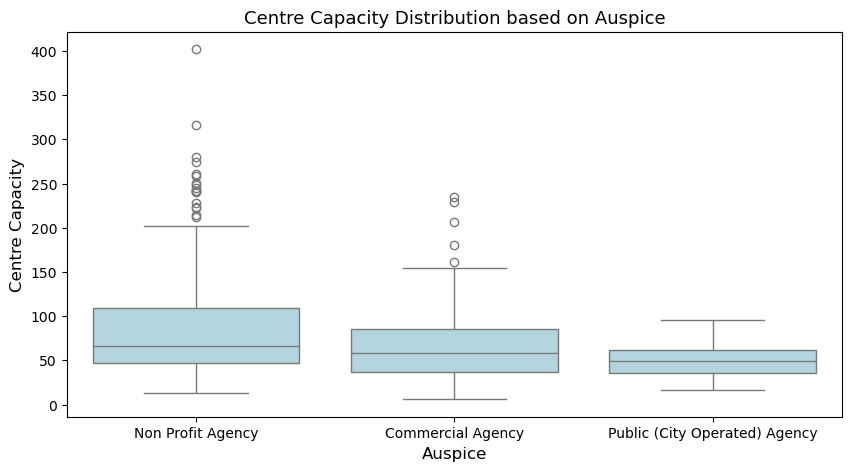

In [16]:
##### ANOVA One Way - II  #####
### To see the effect of auspice on total centre capacity ###

# H0: The centre total capacity means across auspice groups are all equal 
# H1: There is at least one difference in centre total capacity means among the auspice groups


# Creating new DF with relevant columns
Auspice_Cap_DF = Data[['AUSPICE', 'Total_Cap']]

# Plotting boxplot to the capacity distribution across the age groups

# Setting plot dimensions
plt.figure(figsize=(10, 5))

ax = sns.boxplot(x='AUSPICE', y='Total_Cap', data=Auspice_Cap_DF, color='lightblue')

# Adding title and axis names
plt.xlabel('Auspice',size = 12) 
plt.ylabel('Centre Capacity',size = 12) 
plt.title('Centre Capacity Distribution based on Auspice', size = 13) 

# Display graph
plt.show()


In [17]:
# Running one-way ANOVA 
AuspiceCap_ANOVA_Res = stat()
AuspiceCap_ANOVA_Res.anova_stat(df=Auspice_Cap_DF, res_var='Total_Cap', anova_model='Total_Cap ~ C(AUSPICE)')
# ANOVA Results Table
AuspiceCap_ANOVATable = pd.DataFrame(round(AuspiceCap_ANOVA_Res.anova_summary, 3))

# Printing ANOVA table
display(AuspiceCap_ANOVATable)

# Adding space between the outputs 
print (" ")

# Defining level of significance
level_of_sig = 0.05

# Printing conclusion of test
if(AuspiceCap_ANOVATable['PR(>F)'][0] != '0.0'):
    if(AuspiceCap_ANOVATable['PR(>F)'][0] < level_of_sig):
        print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the centre total capacity means of different auspice groups")
    else:
        print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove signficant differences among the centre total capacity means of different auspice groups")   
    
else:
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the centre total capacity means of different auspice groups")
  

,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,96112.114,48056.057,21.843,0.0
Residual,1060.0,2332065.265,2200.062,NaN,NaN


 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the centre total capacity means of different auspice groups


In [18]:
# Post hoc test for multiple pairwise comparisons using Tukey's HSD Test
AuspiceCap_ANOVA_Res.tukey_hsd(df=Auspice_Cap_DF, res_var='Total_Cap', xfac_var='AUSPICE', anova_model='Total_Cap ~ C(AUSPICE)')
AuspiceCap_ANOVA_Res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,17.119417,9.703599,24.535235,7.662434,0.001000
1,Non Profit Agency,Public (City Operated) Agency,34.334610,16.224077,52.445142,6.292710,0.001000
2,Commercial Agency,Public (City Operated) Agency,17.215193,-1.453146,35.883531,3.060857,0.077966


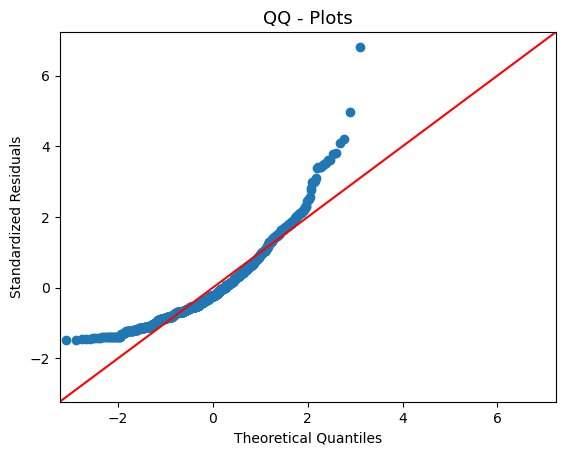

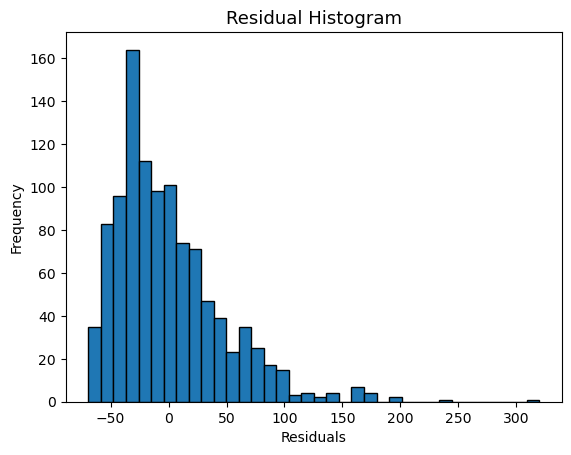

In [19]:
# Checking anova model diagnostics

# Assumption 1: res.anova_std_residuals are standardized residuals obtained from ANOVA
sm.qqplot(AuspiceCap_ANOVA_Res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title('QQ - Plots', size = 13) 
plt.show()

# histogram
plt.hist(AuspiceCap_ANOVA_Res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.title('Residual Histogram', size = 13) 


# show plot
plt.show()

In [20]:
# Assumption 1: Residuals are normally distributed; testing using Shapiro Wilk test
# H0: Data is normally distributed
# H1: Data is not normally distributed

# Defining level of significance
level_of_sig = 0.05

# Running test
w_auspice, p_val_auspice = stats.shapiro(AuspiceCap_ANOVA_Res.anova_model_out.resid)

w_auspice = round(w_auspice, 3)
p_val_auspice = round(p_val_auspice, 3)
# Printing results
print('Auspice Groups - Test statistic :', w_auspice)

if(p_val_auspice == 0.0):
    print('Auspice Groups - p-value < 0.001')
else:
    print('Auspice Groups - p-value :',p_val_auspice)    


# Adding space between the outputs 
print(' ')

# Printing conclusion of test
if(p_val_auspice < level_of_sig):
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there is sample is not normally distributed")
else:
    print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove that the data is not normally distributed")   

Auspice Groups - Test statistic : 0.902
Auspice Groups - p-value < 0.001
 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there is sample is not normally distributed


In [21]:
# Assumption 2: Homogeneity of variances ; testing using Levene's test as data is not normally distributed
# H0: Groups have equal variances
# H1: Groups do not equal variances

AuspiceCap_ANOVA_Res.levene(df=Auspice_Cap_DF, res_var='Total_Cap', xfac_var='AUSPICE')
AuspiceGroup_LeveneRes = pd.DataFrame(AuspiceCap_ANOVA_Res.levene_summary)

# Defining level of significance
level_of_sig = 0.05

# Round the values to 3 decimal places 
AuspiceGroup_LeveneRes['Value'] = AuspiceGroup_LeveneRes['Value'].apply(lambda x: round(x, 3))

# # Relabelling p-value
if(AuspiceGroup_LeveneRes['Value'][2] == 0.0):
    AuspiceGroup_LeveneRes['Value'][2] = '< 0.001'

display(AuspiceGroup_LeveneRes)

# Adding space between the outputs 
print(' ')

# Printing conclusion of test
if(AuspiceGroup_LeveneRes['Value'][2] != '< 0.001'):
    if(AuspiceGroup_LeveneRes['Value'][2] < level_of_sig):
        print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous")
    else:
        print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove the variances are not homogenuous")   
    
else:
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous")
    


,Parameter,Value
0,Test statistics (W),17.927
1,Degrees of freedom (Df),2.0
2,p value,< 0.001


 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the variances are not homogenuous


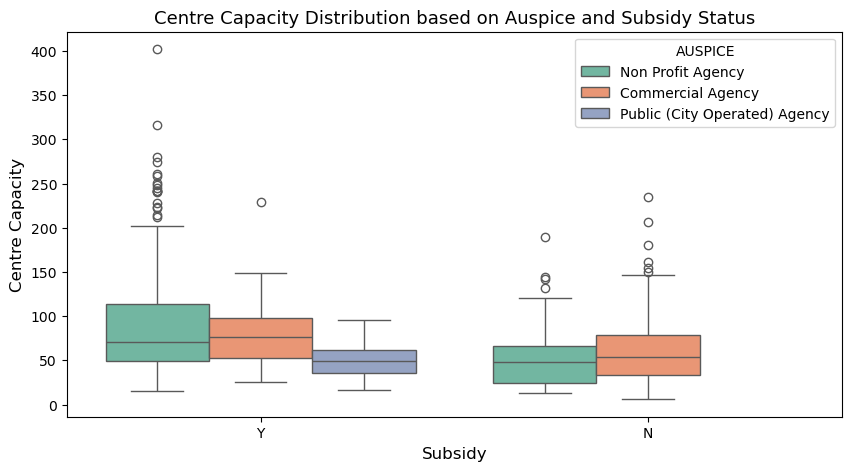

In [22]:
##### Two Way ANOVA #####

# 1 Null Hypothesis (H0) : There is no effect of operating auspice group on the centre total capacity 
# 1 Alternate Hypothesis (HA) : There is a significant effect of operating auspice group on the centre total capacity
# 2 Null Hypothesis (H0) : There is no effect of subsidy status on the centre total capacity 
# 2 Alternate Hypothesis (HA) : There is a significant effect of subsidy status on the centre total capacity 
# 3 Null Hypothesis (H0) : There is no effect of the interaction of operating auspice group and subsidy status on the centre total capacity 
# 3 Alternate Hypothesis (HA) : There is a significant effect of the interaction of age group and subsidy status on the centre total capacity


### To see the impact of subsized centres across various auspice groups on total centre capacity ###
# Creating new DF with relevant columns
Subsidy_Auspice_DF = Data[['AUSPICE', 'subsidy', 'Total_Cap']]

# Plotting grouped boxplots to see capacity distribution

# Setting plot dimensions
plt.figure(figsize=(10, 5))

ax = sns.boxplot(x="subsidy", y="Total_Cap", hue="AUSPICE", data=Subsidy_Auspice_DF, palette="Set2")

# Adding title and axis names
plt.xlabel('Subsidy',size = 12) 
plt.ylabel('Centre Capacity',size = 12) 
plt.title('Centre Capacity Distribution based on Auspice and Subsidy Status', size = 13) 

# Display graph
plt.show()


In [23]:
# Running two-way ANOVA 
Subsidy_Auspice_ANOVA_Res = stat()
Subsidy_Auspice_ANOVA_Res.anova_stat(df=Subsidy_Auspice_DF, res_var='Total_Cap', anova_model='Total_Cap ~ C(AUSPICE) + C(subsidy) + C(AUSPICE):C(subsidy)')
# ANOVA Results Table
Subsidy_Auspice_ANOVATable = pd.DataFrame(round(Subsidy_Auspice_ANOVA_Res.anova_summary, 3))

# Printing ANOVA table
display(Subsidy_Auspice_ANOVATable)

# Adding space between the outputs 
print (" ")

# Defining level of significance
level_of_sig = 0.05

# Printing conclusion of test
# For Main Effect - AUSPICE - 
if(Subsidy_Auspice_ANOVATable['PR(>F)'][0] != '0.0'):
    if(Subsidy_Auspice_ANOVATable['PR(>F)'][0] < level_of_sig):
        print("MAIN EFFECT (AUSPICE) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice groups")
    else:
        print("MAIN EFFECT (AUSPICE) Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove signficant differences among the total centre capacities mean of different auspice groups")   
    
else:
    print("MAIN EFFECT (AUSPICE) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice groups")

 
    # For Main Effect (subsidy) 
print(" ")
if(Subsidy_Auspice_ANOVATable['PR(>F)'][1] != '0.0'):
    if(Subsidy_Auspice_ANOVATable['PR(>F)'][1] < level_of_sig):
        print("MAIN EFFECT (SUBSIDY) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different subsidy status groups")
    else:
        print("MAIN EFFECT (SUBSIDY) Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove signficant differences among the total centre capacities mean of different subsidy status groups")   
    
else:
    print("MAIN EFFECT (SUBSIDY) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different subsidy status groups")

    # For Interaction Effect - 
print(" ")
if(Subsidy_Auspice_ANOVATable['PR(>F)'][2] != '0.0'):
    if(Subsidy_Auspice_ANOVATable['PR(>F)'][2] < level_of_sig):
        print("INTERACTION EFFECT Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice and subsidy status groups")
    else:
        print("INTERACTION EFFECT Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove signficant differences among the total centre capacities mean of different auspice and subsidy status groups")   
    
else:
    print("INTERACTION EFFECT Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice and subsidy status groups")

 

,df,sum_sq,mean_sq,F,PR(>F)
C(AUSPICE),2.0,17136.289,8568.144,4.115,0.043
C(subsidy),1.0,83527.442,83527.442,40.118,0.000
C(AUSPICE):C(subsidy),2.0,56034.454,28017.227,13.457,0.000
Residual,1058.0,2202809.388,2082.050,NaN,NaN


 
MAIN EFFECT (AUSPICE) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice groups
 
MAIN EFFECT (SUBSIDY) Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different subsidy status groups
 
INTERACTION EFFECT Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that there are signficant differences among the total centre capacities mean of different auspice and subsidy status groups


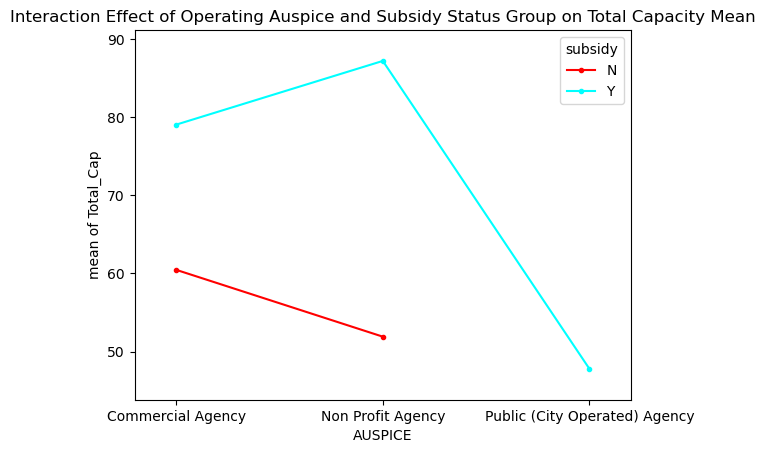

In [24]:
# Interaction Plot 

# Calling libraries
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

# Plotting
fig = interaction_plot(x=Subsidy_Auspice_DF['AUSPICE'],
                       trace=Subsidy_Auspice_DF['subsidy'],
                       response=Subsidy_Auspice_DF['Total_Cap'])

plt.title("Interaction Effect of Operating Auspice and Subsidy Status Group on Total Capacity Mean")
plt.show()

In [25]:
# Post hoc test for multiple pairwise comparisons using Tukey's HSD Test
# Main Effect - Auspice
Subsidy_Auspice_ANOVA_Res.tukey_hsd(df=Subsidy_Auspice_DF, res_var='Total_Cap', xfac_var='AUSPICE', anova_model='Total_Cap ~ C(AUSPICE) + C(subsidy) + C(AUSPICE):C(subsidy)')
Subsidy_Auspice_ANOVA_Res.tukey_summary


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,17.119417,9.905213,24.333621,7.876596,0.001000
1,Non Profit Agency,Public (City Operated) Agency,34.334610,16.716448,51.952772,6.468588,0.001000
2,Commercial Agency,Public (City Operated) Agency,17.215193,-0.945610,35.375996,3.146407,0.067567


In [26]:
# Post hoc test for multiple pairwise comparisons using Tukey's HSD Test
# Main Effect - Subsidy Status
Subsidy_Auspice_ANOVA_Res.tukey_hsd(df=Subsidy_Auspice_DF, res_var='Total_Cap', xfac_var='subsidy', anova_model='Total_Cap ~ C(AUSPICE) + C(subsidy) + C(AUSPICE):C(subsidy)')
Subsidy_Auspice_ANOVA_Res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Y,N,26.265831,20.400592,32.13107,12.426982,0.001


In [27]:
# Post hoc test for multiple pairwise comparisons using Tukey's HSD Test
#Interaction effect between Auspice and subsidy status groups on overall capacity
Subsidy_Auspice_ANOVA_Res.tukey_hsd(df=Subsidy_Auspice_DF, res_var='Total_Cap', xfac_var=['AUSPICE', 'subsidy'], anova_model='Total_Cap ~ C(AUSPICE) + C(subsidy) + C(AUSPICE):C(subsidy)')
Subsidy_Auspice_ANOVA_Res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,"(Non Profit Agency, Y)","(Non Profit Agency, N)",35.327657,21.377488,49.277825,10.224542,0.001000
1,"(Non Profit Agency, Y)","(Commercial Agency, Y)",8.165515,-7.512442,23.843471,2.102822,0.650278
2,"(Non Profit Agency, Y)","(Commercial Agency, N)",26.764597,16.861524,36.667669,10.911871,0.001000
3,"(Non Profit Agency, Y)","(Public (City Operated) Agency, Y)",39.460387,17.934574,60.986199,7.401338,0.001000
4,"(Non Profit Agency, Y)","(Public (City Operated) Agency, N)",0.000000,-inf,inf,0.000000,0.900000
5,"(Non Profit Agency, N)","(Commercial Agency, Y)",27.162142,7.567922,46.756362,5.596861,0.001135
6,"(Non Profit Agency, N)","(Commercial Agency, N)",8.563060,-6.805934,23.932054,2.249531,0.590448
7,"(Non Profit Agency, N)","(Public (City Operated) Agency, Y)",4.132730,-20.392680,28.658140,0.680345,0.900000
8,"(Non Profit Agency, N)","(Public (City Operated) Agency, N)",0.000000,-inf,inf,0.000000,0.900000
9,"(Commercial Agency, Y)","(Commercial Agency, N)",18.599082,1.646292,35.551872,4.429542,0.021963


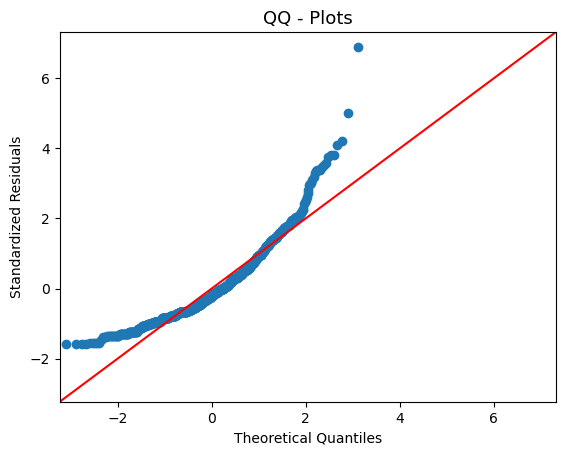

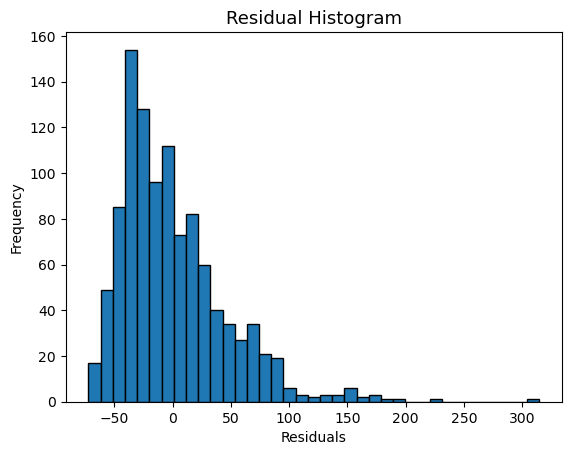

In [28]:
# Checking anova model diagnostics

# Assumption 1: res.anova_std_residuals are standardized residuals obtained from ANOVA
sm.qqplot(Subsidy_Auspice_ANOVA_Res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.title('QQ - Plots', size = 13) 
plt.show()

# histogram
plt.hist(Subsidy_Auspice_ANOVA_Res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.title('Residual Histogram', size = 13) 


# show plot
plt.show()

In [29]:
# Assumption 1: Residuals are normally distributed; testing using Shapiro Wilk test
# H0: Data is normally distributed
# H1: Data is not normally distributed

# Defining level of significance
level_of_sig = 0.05

# Running test
w_auspice_subsidy, p_val_auspice_subsidy = stats.shapiro(Subsidy_Auspice_ANOVA_Res.anova_model_out.resid)

w_auspice_subsidy = round(w_auspice_subsidy, 3)
p_val_auspice_subsidy = round(p_val_auspice_subsidy, 3)
# Printing results
print('Auspice - Subsidy Groups - Test statistic :', w_auspice_subsidy)

if(p_val_auspice_subsidy == 0.0):
    print('Auspice - Subsidy Groups - p-value < 0.001')
else:
    print('Auspice- Subsidy Groups - p-value :',p_val_auspice_subsidy)    


# Adding space between the outputs 
print(' ')

# Printing conclusion of test
if(p_val_auspice_subsidy < level_of_sig):
    print("Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the data is not normally distributed")
else:
    print("Conclusion : Since the p-value is greater than alpha, we do not reject the null hypothesis and conclude that there is not enough evidence to prove that the data is not normally distributed")   

Auspice - Subsidy Groups - Test statistic : 0.902
Auspice - Subsidy Groups - p-value < 0.001
 
Conclusion : Since the p-value is less than alpha, we reject the null hypothesis and conclude that the data is not normally distributed


In [30]:
# Assumption 2: Homogeneity of variances ; testing using Levene's test as data is not normally distributed
Subsidy_Auspice_ANOVA_Res.levene(df=Subsidy_Auspice_DF, res_var='Total_Cap', xfac_var=['AUSPICE', 'subsidy'])
Subsidy_Auspice_LeveneRes = pd.DataFrame(Subsidy_Auspice_ANOVA_Res.levene_summary)

# Defining level of significance
level_of_sig = 0.05

# Round the values to 3 decimal places 
Subsidy_Auspice_LeveneRes['Value'] = Subsidy_Auspice_LeveneRes['Value'].apply(lambda x: round(x, 3))

# # Relabelling p-value
if(Subsidy_Auspice_LeveneRes['Value'][2] == 0.0):
    Subsidy_Auspice_LeveneRes['Value'][2] = '< 0.001'

display(Subsidy_Auspice_LeveneRes)

# Adding space between the outputs 
print(' ')

print("Conclusion : Since the p-value is NaN, the test is inconclusive")
    


,Parameter,Value
0,Test statistics (W),NaN
1,Degrees of freedom (Df),5.0
2,p value,NaN


 
Conclusion : Since the p-value is NaN, the test is inconclusive
